In [1]:
from typing import TypedDict, List, Dict, Any, Optional
from datetime import datetime, timedelta
from sqlalchemy.orm import Session
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END
from enum import Enum, auto
import logging
import os
import json
from dotenv import load_dotenv
load_dotenv()

from app.models.user import User
from app.services.telemetry_service import TelemetryService
from app.services.device_service import DeviceService

logger = logging.getLogger(__name__)

# Configuration
OPENAI_MODEL = "gpt-4o"
llm = ChatOpenAI(
    model_name=OPENAI_MODEL,
    temperature=0.0,
    openai_api_key=os.environ.get("OPENAI_API_KEY")
)


In [2]:
# State definitions
class InputState(TypedDict):
    chat_id: str
    query: str
    user_id: int

class OutputState(TypedDict):
    chat_id: str
    answer: str
    data: Optional[Dict[str, Any]]

class InternalState(InputState, total=False):
    intent: str
    parsed_query: Dict[str, Any]
    answer: str
    data: Optional[Dict[str, Any]]

In [8]:
# Intent classification
class QueryIntent(Enum):
    ENERGY_USAGE = auto()
    DEVICE_COMPARISON = auto()
    TOP_CONSUMERS = auto()
    ENERGY_SUMMARY = auto()
    DEVICE_LIST = auto()
    GREETING = auto()
    THANKS = auto()
    GOODBYE = auto()
    OFF_TOPIC = auto()

def classify_intent(query: str) -> QueryIntent:
    """Classify the intent of the user query"""
    system_prompt = SystemMessage(content="""
    You are an energy monitoring assistant. Classify the user's intent into one of these categories:
    
    - ENERGY_USAGE: Questions about specific device energy consumption
    - DEVICE_COMPARISON: Comparing energy usage between devices
    - TOP_CONSUMERS: Finding highest energy consuming devices
    - ENERGY_SUMMARY: General energy usage summaries or statistics
    - DEVICE_LIST: Listing devices or device information
    - GREETING: Hello, hi, greetings
    - THANKS: Thank you, thanks
    - GOODBYE: Goodbye, bye, see you
    - OFF_TOPIC: Not related to energy monitoring
    
    Respond with ONLY the intent category.
    """)
    
    response = llm.invoke([system_prompt, HumanMessage(content=query)])
    intent_str = response.content.strip().upper()
    
    try:
        return QueryIntent[intent_str]
    except (KeyError, ValueError):
        return QueryIntent.OFF_TOPIC

def parse_energy_query(query: str) -> Dict[str, Any]:
    """Parse energy-related queries to extract parameters"""
    system_prompt = SystemMessage(content="""
    Parse the user's energy monitoring query and extract relevant parameters.
    Return a JSON object with these fields:
    
    {
        "device_name": "device name if specified",
        "device_type": "device type if specified", 
        "time_period": "time period (today, yesterday, last_week, last_month, specific_hours)",
        "start_time": "start time if specified",
        "end_time": "end_time if specified",
        "comparison": "true if comparing devices",
        "aggregation": "type of aggregation (total, average, max, min)",
        "limit": "number of results to return"
    }
    
    Only include fields that are relevant to the query. Use null for unspecified values.
    """)
    
    try:
        response = llm.invoke([system_prompt, HumanMessage(content=query)])
        return json.loads(response.content)
    except Exception as e:
        logger.error(f"Error parsing query: {e}")
        return {}

def get_time_range(time_period: str) -> tuple[Optional[datetime], Optional[datetime]]:
    """Convert time period to start and end times"""
    now = datetime.utcnow()
    
    if time_period == "today":
        start = now.replace(hour=0, minute=0, second=0, microsecond=0)
        return start, now
    elif time_period == "yesterday":
        start = (now - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
        end = start.replace(hour=23, minute=59, second=59)
        return start, end
    elif time_period == "last_week":
        start = (now - timedelta(days=7)).replace(hour=0, minute=0, second=0, microsecond=0)
        return start, now
    elif time_period == "last_month":
        start = (now - timedelta(days=30)).replace(hour=0, minute=0, second=0, microsecond=0)
        return start, now
    else:
        return None, None

def generate_response(state: InternalState, db: Session) -> InternalState:
    """Generate response based on intent and parsed query"""
    intent = QueryIntent[state["intent"]]
    parsed_query = state.get("parsed_query", {})
    
    if intent in [QueryIntent.GREETING, QueryIntent.THANKS, QueryIntent.GOODBYE, QueryIntent.OFF_TOPIC]:
        return generate_small_talk_response(state)
    
    try:
        if intent == QueryIntent.ENERGY_USAGE:
            return handle_energy_usage_query(state, parsed_query, db)
        elif intent == QueryIntent.DEVICE_COMPARISON:
            return handle_device_comparison_query(state, parsed_query, db)
        elif intent == QueryIntent.TOP_CONSUMERS:
            return handle_top_consumers_query(state, parsed_query, db)
        elif intent == QueryIntent.ENERGY_SUMMARY:
            return handle_energy_summary_query(state, parsed_query, db)
        elif intent == QueryIntent.DEVICE_LIST:
            return handle_device_list_query(state, db)
        else:
            return generate_fallback_response(state)
    except Exception as e:
        logger.error(f"Error generating response: {e}")
        return generate_error_response(state)

def generate_small_talk_response(state: InternalState) -> InternalState:
    """Generate small talk responses"""
    intent = QueryIntent[state["intent"]]
    
    if intent == QueryIntent.GREETING:
        response = "Hello! I'm your smart home energy assistant. I can help you monitor your energy usage, compare devices, and find ways to save energy. What would you like to know about your energy consumption?"
    elif intent == QueryIntent.THANKS:
        response = "You're welcome! Feel free to ask me anything about your energy usage anytime."
    elif intent == QueryIntent.GOODBYE:
        response = "Goodbye! Have a great day and remember to monitor your energy usage!"
    else:
        response = "I'm here to help you with energy monitoring questions. You can ask me about device energy usage, comparisons, or energy summaries."
    
    return {**state, "answer": response}

def handle_energy_usage_query(state: InternalState, parsed_query: Dict[str, Any], db: Session) -> InternalState:
    """Handle energy usage queries for specific devices"""
    device_name = parsed_query.get("device_name")
    time_period = parsed_query.get("time_period", "today")
    start_time, end_time = get_time_range(time_period)
    
    # Get user's devices
    devices = DeviceService.get_user_devices(db, state["user_id"])
    
    if device_name:
        # Find specific device
        target_device = None
        for device in devices:
            if device.name.lower() == device_name.lower():
                target_device = device
                break
        
        if not target_device:
            return {**state, "answer": f"I couldn't find a device named '{device_name}'. Here are your devices: {', '.join([d.name for d in devices])}"}
        
        # Get energy data for specific device
        telemetry_data = TelemetryService.get_telemetry_by_device(
            db, target_device.device_id, state["user_id"], start_time, end_time, limit=100
        )
        
        if not telemetry_data:
            return {**state, "answer": f"No energy data found for {device_name} in the specified time period."}
        
        # Calculate summary
        total_energy = sum(t.energy_watts for t in telemetry_data)
        avg_energy = total_energy / len(telemetry_data)
        max_energy = max(t.energy_watts for t in telemetry_data)
        
        response = f"Energy usage for {device_name} ({time_period}):\n"
        response += f"• Average power: {avg_energy:.1f} watts\n"
        response += f"• Peak power: {max_energy:.1f} watts\n"
        response += f"• Total readings: {len(telemetry_data)}"
        
        return {**state, "answer": response, "data": {
            "device_name": device_name,
            "average_power": avg_energy,
            "max_power": max_energy,
            "readings_count": len(telemetry_data)
        }}
    
    else:
        # Get summary for all devices
        summary = TelemetryService.get_energy_summary(db, state["user_id"], start_time=start_time, end_time=end_time)
        
        response = f"Energy summary for all devices ({time_period}):\n"
        response += f"• Average power: {summary['average_power_watts']:.1f} watts\n"
        response += f"• Peak power: {summary['max_power_watts']:.1f} watts\n"
        response += f"• Total readings: {summary['reading_count']}"
        
        return {**state, "answer": response, "data": summary}

def handle_device_comparison_query(state: InternalState, parsed_query: Dict[str, Any], db: Session) -> InternalState:
    """Handle device comparison queries"""
    top_consumers = TelemetryService.get_top_consuming_devices(db, state["user_id"], limit=5)
    
    if not top_consumers:
        return {**state, "answer": "No energy data available for device comparison."}
    
    response = "Top energy consuming devices:\n"
    for i, device in enumerate(top_consumers, 1):
        response += f"{i}. {device['name']} ({device['type']}): {device['average_power_watts']:.1f} watts\n"
    
    return {**state, "answer": response, "data": {"top_consumers": top_consumers}}

def handle_top_consumers_query(state: InternalState, parsed_query: Dict[str, Any], db: Session) -> InternalState:
    """Handle top consumers queries"""
    limit = parsed_query.get("limit", 5)
    top_consumers = TelemetryService.get_top_consuming_devices(db, state["user_id"], limit=limit)
    
    if not top_consumers:
        return {**state, "answer": "No energy data available."}
    
    response = f"Top {len(top_consumers)} energy consuming devices:\n"
    for i, device in enumerate(top_consumers, 1):
        response += f"{i}. {device['name']} ({device['type']}): {device['average_power_watts']:.1f} watts\n"
    
    return {**state, "answer": response, "data": {"top_consumers": top_consumers}}

def handle_energy_summary_query(state: InternalState, parsed_query: Dict[str, Any], db: Session) -> InternalState:
    """Handle energy summary queries"""
    time_period = parsed_query.get("time_period", "today")
    start_time, end_time = get_time_range(time_period)
    
    summary = TelemetryService.get_energy_summary(db, state["user_id"], start_time=start_time, end_time=end_time)
    
    response = f"Energy summary ({time_period}):\n"
    response += f"• Average power: {summary['average_power_watts']:.1f} watts\n"
    response += f"• Peak power: {summary['max_power_watts']:.1f} watts\n"
    response += f"• Minimum power: {summary['min_power_watts']:.1f} watts\n"
    response += f"• Total readings: {summary['reading_count']}"
    
    return {**state, "answer": response, "data": summary}

def handle_device_list_query(state: InternalState, db: Session) -> InternalState:
    """Handle device list queries"""
    devices = DeviceService.get_user_devices(db, state["user_id"])
    
    if not devices:
        return {**state, "answer": "You don't have any devices registered yet."}
    
    response = "Your registered devices:\n"
    for i, device in enumerate(devices, 1):
        status = "Active" if device.is_active else "Inactive"
        response += f"{i}. {device.name} ({device.device_type}) - {status}\n"
    
    return {**state, "answer": response, "data": {"devices": [{"name": d.name, "type": d.device_type, "active": d.is_active} for d in devices]}}

def generate_fallback_response(state: InternalState) -> InternalState:
    """Generate fallback response for unrecognized queries"""
    response = "I'm not sure I understood your question. I can help you with:\n"
    response += "• Energy usage for specific devices\n"
    response += "• Comparing energy consumption between devices\n"
    response += "• Finding your highest energy consuming devices\n"
    response += "• Energy usage summaries\n"
    response += "• Listing your devices"
    
    return {**state, "answer": response}

def generate_error_response(state: InternalState) -> InternalState:
    """Generate error response"""
    response = "Sorry, I encountered an error while processing your request. Please try again or rephrase your question."
    return {**state, "answer": response}

In [9]:
# LangGraph nodes
def classify_intent_node(state: InternalState) -> InternalState:
    """Classify the intent of the user query using LLM"""
    intent = classify_intent(state["query"])
    return {**state, "intent": intent.name}

def parse_query_node(state: InternalState) -> InternalState:
    """Parse the query to extract parameters using LLM"""
    intent = QueryIntent[state["intent"]]
    
    if intent in [QueryIntent.ENERGY_USAGE, QueryIntent.DEVICE_COMPARISON, QueryIntent.TOP_CONSUMERS, QueryIntent.ENERGY_SUMMARY]:
        parsed_query = parse_energy_query(state["query"])
        return {**state, "parsed_query": parsed_query}
    
    return state

def generate_response_node(state: InternalState) -> InternalState:
    """Generate the final response with database integration"""
    # This will be handled by the main service method with database access
    return state

def validate_user_access_node(state: InternalState) -> InternalState:
    """Validate user has access to requested data"""
    # This is a placeholder for future user validation logic
    return state

def enrich_context_node(state: InternalState) -> InternalState:
    """Enrich query context with user preferences and history"""
    # This is a placeholder for future context enrichment
    return state


In [10]:
def create_chat_graph() -> StateGraph:
    """Create the LangGraph for chat processing with enhanced visual structure"""
    workflow = StateGraph(InternalState)
    
    # Add nodes with detailed descriptions for better visualization
    workflow.add_node("classify_intent", classify_intent_node)
    workflow.add_node("validate_user_access", validate_user_access_node)
    workflow.add_node("enrich_context", enrich_context_node)
    workflow.add_node("parse_query", parse_query_node)
    workflow.add_node("generate_response", generate_response_node)
    
    # Set entry point
    workflow.set_entry_point("classify_intent")
    
    # Add conditional edges for better flow visualization
    def route_after_classification(state: InternalState):
        intent = QueryIntent[state["intent"]]
        if intent in [QueryIntent.GREETING, QueryIntent.THANKS, QueryIntent.GOODBYE, QueryIntent.OFF_TOPIC]:
            return "generate_response"  # Skip parsing for small talk
        return "validate_user_access"
    
    def route_after_validation(state: InternalState):
        intent = QueryIntent[state["intent"]]
        if intent in [QueryIntent.ENERGY_USAGE, QueryIntent.DEVICE_COMPARISON, QueryIntent.TOP_CONSUMERS, QueryIntent.ENERGY_SUMMARY]:
            return "enrich_context"  # Add context for complex queries
        return "parse_query"
    
    def route_after_enrichment(state: InternalState):
        return "parse_query"
    
    def route_after_parsing(state: InternalState):
        return "generate_response"
    
    # Add conditional edges
    workflow.add_conditional_edges(
        "classify_intent",
        route_after_classification,
        {
            "validate_user_access": "validate_user_access",
            "generate_response": "generate_response"
        }
    )
    
    workflow.add_conditional_edges(
        "validate_user_access",
        route_after_validation,
        {
            "enrich_context": "enrich_context",
            "parse_query": "parse_query"
        }
    )
    
    workflow.add_conditional_edges(
        "enrich_context",
        route_after_enrichment,
        {
            "parse_query": "parse_query"
        }
    )
    
    workflow.add_conditional_edges(
        "parse_query",
        route_after_parsing,
        {
            "generate_response": "generate_response"
        }
    )
    
    # Add final edge
    workflow.add_edge("generate_response", END)
    
    return workflow.compile()


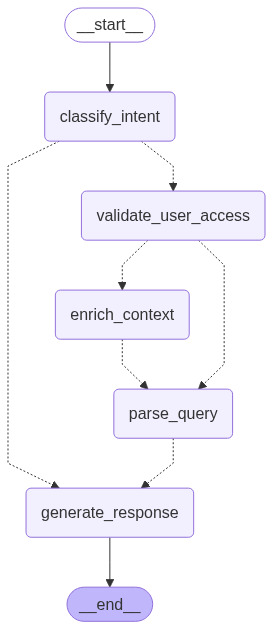

In [11]:
from IPython.display import Image, display
graph = create_chat_graph()
display(Image(graph.get_graph().draw_mermaid_png()))